In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black
from pyspark.sql import functions as F, Window
from manga_recsys.spark import get_spark

spark = get_spark(memory="2g")

In [2]:
from IPython.display import display
from manga_recsys.models.manga import get_manga_tags

manga_info = spark.read.parquet(
    "../data/processed/2022-12-17-metadata-listing/manga_info.parquet"
)

In [3]:
# lets see how long it takes to do this in sql instead of doing it by matrix multiplication
# this is a _lot_ slower than I would have expected

exploded = (
    get_manga_tags(manga_info)
    .select("id", F.explode("tags").alias("tag"))
    .repartition(64)
)
joined = (
    exploded.join(exploded.withColumnRenamed("id", "id2"), on="tag")
    .where("id <> id2")
    .groupBy("id", "id2")
    .count()
)

# NOTE: not really tractable, will OOM with default settings
# joined.show()

In [4]:
from gensim import corpora, matutils

# count the tags per manga, and then find the number of paths to each other manga.
# we might actually want to do this as matrix multiplication instead of a join
# to avoid the cartesian product.

manga_tags = get_manga_tags(manga_info).toPandas()
dictionary = corpora.Dictionary(manga_tags.tags)
corpus = [dictionary.doc2bow(tags) for tags in manga_tags.tags]
corpus[:3]

[[(0, 1), (1, 1), (2, 1)],
 [(3, 1), (4, 1), (5, 1), (6, 1)],
 [(7, 1), (8, 1), (9, 1), (10, 1)]]

In [5]:
tag_manga_mat = matutils.corpus2csc(corpus, num_terms=len(dictionary))
tag_manga_mat.shape

(76, 64464)

In [21]:
# now get the number of paths between each manga, this takes a little under half
# a minute.
manga_manga_mat = (tag_manga_mat.T @ tag_manga_mat).astype("float32").todense()
manga_manga_mat.shape, manga_manga_mat.dtype

((64464, 64464), dtype('float32'))

In [18]:
# count sparsity of matrix
import numpy as np

np.count_nonzero(manga_manga_mat) / manga_manga_mat.size

1.0

In [20]:
# compute the graph laplacian in place
# https://csustan.csustan.edu/~tom/Clustering/GraphLaplacian-tutorial.pdf
# NOTE: normalized is also stupid slow
from scipy.sparse.csgraph import laplacian

laplacian(manga_manga_mat, normed=True, copy=False)
manga_manga_mat.shape, manga_manga_mat.dtype

((64464, 64464), dtype('float32'))

In [6]:
# what does it look like when we embed the matrix using laplacian eigenmaps?
import matplotlib.pyplot as plt
from sklearn.manifold import SpectralEmbedding

# NOTE: this takes way too long, going to try something else (stopped at the 15
# minute mark)

# reducer = SpectralEmbedding(n_components=2, affinity="precomputed")
# emb = reducer.fit_transform(manga_manga_mat)

# plt.scatter(emb[:, 0], emb[:, 1])
# plt.title("embedding of manga-manga matrix")
# plt.show()

In [18]:
# embed using UMAP
import umap

reducer = umap.UMAP(n_components=2, metric="cosine", low_memory=True)
emb = reducer.fit_transform(np.asarray(manga_manga_mat))

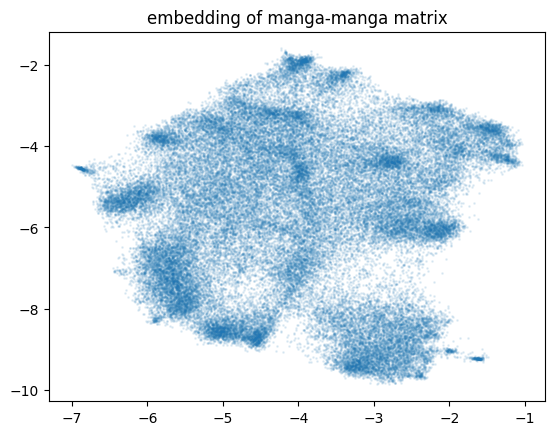

In [21]:
plt.scatter(emb[:, 0], emb[:, 1], s=1, alpha=0.1)
plt.title("embedding of manga-manga matrix")
plt.show()

In [8]:
from scipy.linalg import eig
import numpy as np
from scipy.sparse.csgraph import laplacian

# perform deconvolution on a test matrix to check dimensions

test_X = np.random.uniform(0, 1, (10, 10))

lam, lhs, rhs = eig(test_X, left=True, right=True)

# rescale the eigenvectors
lam_dir = lam / (1 + lam)
lam_dir

# recover the original matrix keeping only the real parts
rec_X = lhs @ np.diag(lam_dir) @ rhs
rec_X.real

array([[-2.32878221e-01, -9.12705244e-02, -1.16740187e-01,
        -5.75085552e-02,  1.51646212e-01,  2.99051878e-01,
         1.47152096e-01, -3.52432409e-03,  2.34314219e-01,
        -7.63352048e-02],
       [ 3.62546552e-01,  2.49169080e-01, -2.93908701e-01,
        -2.50754033e-01,  4.79938720e-02, -5.74828220e-02,
        -1.40872488e-01,  2.57772981e-01, -1.58419939e-01,
         4.75019981e-02],
       [ 2.38718887e-04,  6.34936057e-02,  4.32285348e-02,
        -1.01608240e-02, -1.28722278e-01,  1.99532281e-01,
         2.42232600e-02,  3.69904015e-02,  2.07137549e-01,
        -8.05486138e-03],
       [ 1.46575735e-01, -1.61667416e-01, -1.24039521e-01,
        -8.31150156e-02, -3.26978491e-02,  1.47022452e-01,
         5.38366355e-02,  1.34968478e-02, -5.36955083e-02,
        -8.29346938e-02],
       [ 2.25714158e-01,  6.19313596e-02, -3.26173437e-01,
        -1.95657494e-01,  1.73821996e-01, -1.18497369e-01,
         1.60593864e-02,  7.06138928e-02,  1.48949879e-02,
         1.

In [9]:
manga_manga_mat = (tag_manga_mat.T @ tag_manga_mat).astype("float32").todense()

# set the diagonal to zero
np.fill_diagonal(manga_manga_mat, 0)

In [10]:
# now lets try to use the deconvolution algorithm to remove indirect paths
# find the eigen-decomposition of the matrix
from scipy.linalg import eig
import numpy as np
from scipy.sparse.csgraph import laplacian


lam, lhs, rhs = eig(manga_manga_mat)

# rescale the eigenvectors
lam_dir = lam / (1 + lam)

# recover the true matrix
rec_G = lhs @ np.diag(lam_dir) @ rhs
rec_G

In [ ]:
rec_G_real = rec_G.real

In [ ]:
laplacian(rec_G_real, normed=True, copy=False)